# Description

Brief project based on problem described here: 
https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation?fbclid=IwZXh0bgNhZW0CMTAAAR3R8LNHMMQamXoem-buA-B4Goukxvf48MwMSSacRkek7AIjZW0Z2RBKOmM_aem_f8wXdt3QNhMOui1j4ZSYLg

# Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models_pytorch as smp

import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

# Hyperparameters

In [14]:
PATH = 'C://Users/winal/ml projekt/'

BATCH_SIZE = 8
PATCH_SIZE = (512, 512)   

torch.manual_seed(42) 

LEARNING_RATE = 0.001
EARLY_STOP = 4
NUM_EPOCHS = 10

# Data preprocessing

In [3]:
df = pd.read_csv(PATH + 'metadata.csv')
df.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [4]:
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)
df.head()

,Image,Mask
0,C://Users/winal/ml projekt/Image/0.jpg,C://Users/winal/ml projekt/Mask/0.png
1,C://Users/winal/ml projekt/Image/1.jpg,C://Users/winal/ml projekt/Mask/1.png
2,C://Users/winal/ml projekt/Image/2.jpg,C://Users/winal/ml projekt/Mask/2.png
3,C://Users/winal/ml projekt/Image/3.jpg,C://Users/winal/ml projekt/Mask/3.png
4,C://Users/winal/ml projekt/Image/4.jpg,C://Users/winal/ml projekt/Mask/4.png


# Sample images

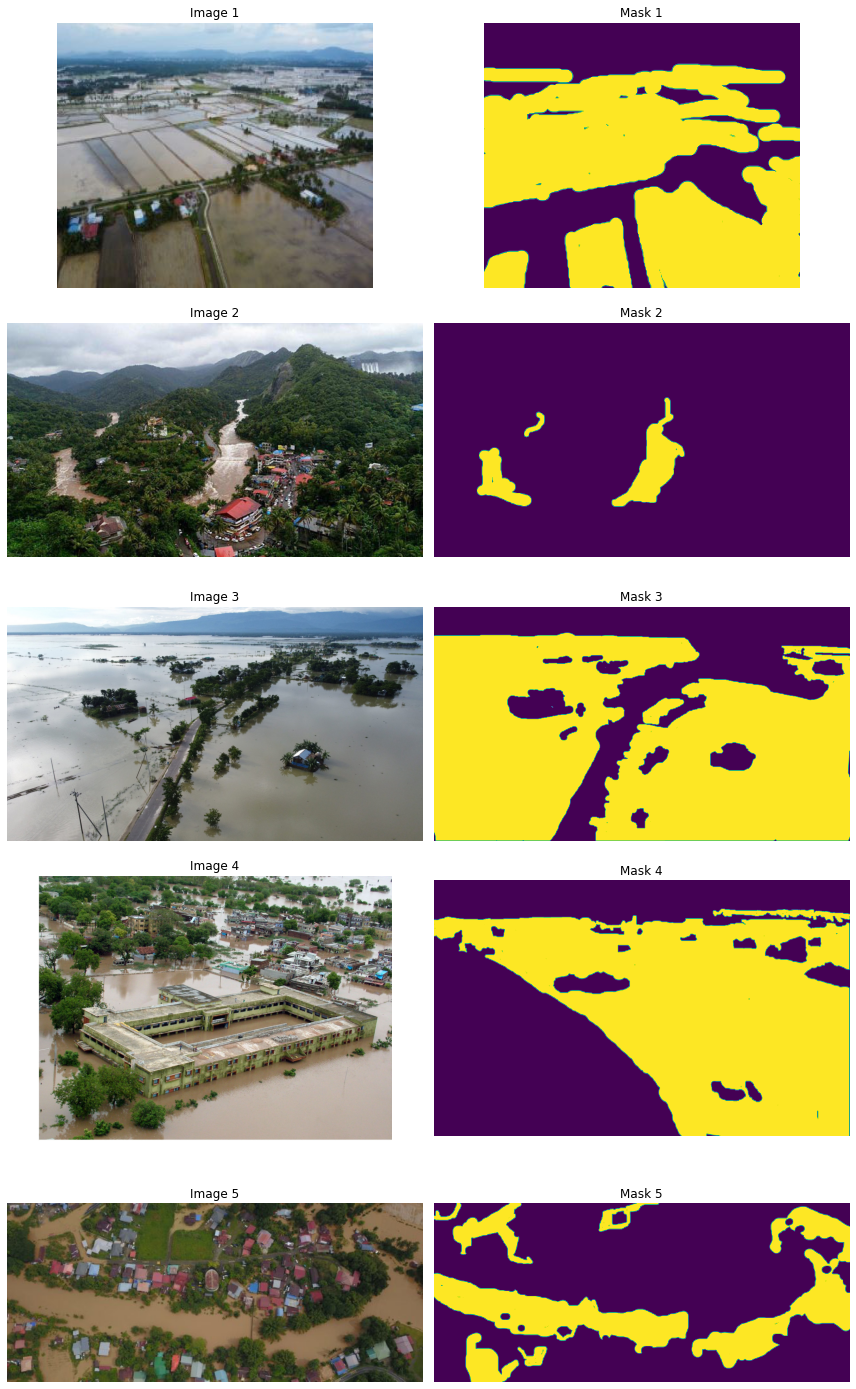

In [5]:
samples = df.sample(n=5)
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

for i, (idx, row) in enumerate(samples.iterrows()):
    img = plt.imread(row['Image'])
    mask = plt.imread(row['Mask'])
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(str('Image ' + str(i+1)))
    
    axes[i, 1].imshow(mask)
    axes[i, 1].set_title(str('Mask ' + str(i+1)))
    
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Creating the dataset

In [6]:
class FloodAreaDataset(Dataset):
    def __init__(self, df, image_transform=None, mask_transform=None):
        self.df = df
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["Image"]
        mask_path = self.df.iloc[idx]["Mask"]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [7]:
image_transform = transforms.Compose([
    transforms.Resize(size=PATCH_SIZE, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=PATCH_SIZE, antialias=False),
    transforms.Lambda(lambda x: x.squeeze().long())
])

dataset = FloodAreaDataset(df, image_transform=image_transform, mask_transform=mask_transform)

In [8]:
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

train_dataset = FloodAreaDataset(train_df, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = FloodAreaDataset(val_df, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = FloodAreaDataset(test_df, image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model architecture

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)    

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, dropout_rate=0.1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, dropout_rate=dropout_rate)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UpResNet(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, out_channels, bilinear=True, dropout_rate=0.1):
        super(UpResNet, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels_1, in_channels_1, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels_1 + in_channels_2, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [10]:
class ResNetUNet(nn.Module):
    def __init__(self, in_channels, out_channels, resnet_type="resnet18", bilinear=False, dropout_rate = 0.1):
        super(ResNetUNet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resnet_type = resnet_type
        self.bilinear = bilinear
        self.dropout_rate = dropout_rate
        
        # Define the backbone network
        if self.resnet_type == "resnet18":
            self.backbone_model = torchvision.models.resnet18(weights="DEFAULT")
            self.channel_distribution = [3, 64, 64, 128, 256]
        elif self.resnet_type == "resnet34":
            self.channel_distribution = [3, 64, 64, 128, 256]
            self.backbone_model = torchvision.models.resnet34(weights="DEFAULT")
        elif self.resnet_type == "resnet50":
            self.channel_distribution = [3, 64, 256, 512, 1024]
            self.backbone_model = torchvision.models.resnet50(weights="DEFAULT")
        else:
            print("Resnet type is not recognized. Loading ResNet 18 as backbone model")
            self.channel_distribution = [3, 64, 64, 128, 256]
            self.backbone_model = torchvision.models.resnet34(weights="DEFAULT")
        
        self.backbone_layers = list(self.backbone_model.children())
        
        # Define the ResNetUNet
        self.inc = DoubleConv(in_channels, 64)
        
        self.block1 = nn.Sequential(*self.backbone_layers[0:3])
        self.block2 = nn.Sequential(*self.backbone_layers[3:5])
        self.block3 = nn.Sequential(*self.backbone_layers[5])
        self.block4 = nn.Sequential(*self.backbone_layers[6])
        
        self.up1 = Up(self.channel_distribution[-1], self.channel_distribution[-2], bilinear=bilinear, dropout_rate = dropout_rate)
        self.up2 = Up(self.channel_distribution[-2], self.channel_distribution[-3], bilinear=bilinear, dropout_rate = dropout_rate)
        self.up3 = UpResNet(self.channel_distribution[-3], 64, self.channel_distribution[-4], bilinear=bilinear, dropout_rate = dropout_rate)
        self.up4 = UpResNet(self.channel_distribution[-4], 64, self.channel_distribution[-4], bilinear=bilinear, dropout_rate = dropout_rate)
        
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x0 = self.inc(x)
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)

        y1 = self.up1(x4, x3)
        y2 = self.up2(x3, x2)
        y3 = self.up3(x2, x1)
        y4 = self.up4(x1, x0)

        logits = self.outc(y4)
        
        return logits

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet_unet = ResNetUNet(in_channels=3, out_channels=2, resnet_type="resnet34").to(device)

# Freeze parameters in blocks 1, 2, 3, and 4
for block in [resnet_unet.block1, resnet_unet.block2, resnet_unet.block3, resnet_unet.block4]:
    for param in block.parameters():
        param.requires_grad_(False)

# Model learning

In [15]:
criterion = smp.losses.DiceLoss('multiclass')
optimizer = optim.Adam(resnet_unet.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    resnet_unet.train()
    train_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = resnet_unet(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    resnet_unet.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = resnet_unet(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print and check for early stopping
    print(f'Epoch [{epoch}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        torch.save(resnet_unet.state_dict(), 'best_model.pth')  # Save the best model
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= EARLY_STOP:
        print(f'Early stopping after {EARLY_STOP} epochs without improvement.')
        break

C:\Users\winal\AppData\Local\Temp/ipykernel_27704/2022124005.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch [1/10], Train Loss: 0.1981, Validation Loss: 0.2040
Epoch [2/10], Train Loss: 0.2008, Validation Loss: 0.1965
Epoch [3/10], Train Loss: 0.1962, Validation Loss: 0.1916
Epoch [4/10], Train Loss: 0.1848, Validation Loss: 0.1973
Epoch [5/10], Train Loss: 0.1802, Validation Loss: 0.2072
Epoch [6/10], Train Loss: 0.1815, Validation Loss: 0.2009
Epoch [7/10], Train Loss: 0.1789, Validation Loss: 0.1904
Epoch [8/10], Train Loss: 0.1800, Validation Loss: 0.1904
Epoch [9/10], Train Loss: 0.1698, Validation Loss: 0.1894
Epoch [10/10], Train Loss: 0.1775, Validation Loss: 0.1868


# Model accuracy

In [17]:
def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(device), masks.to(device)
        
        with torch.no_grad():
            outputs = model(images)
        
        # Convert probability maps to binary masks using a threshold
        pred_masks = torch.argmax(outputs, dim=1)
        
        true_masks_np = masks.cpu().detach().numpy()
        pred_masks_np = pred_masks.cpu().detach().numpy()
        
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(pred_masks_np)
    
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)
    
    # Flatten masks for binary classification
    all_true_masks_flat = all_true_masks.flatten()
    all_pred_masks_flat = all_pred_masks.flatten()

    # Calculate and print metrics
    accuracy  = accuracy_score(all_true_masks_flat, all_pred_masks_flat)
    jaccard   = jaccard_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    f1        = f1_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    precision = precision_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')
    recall    = recall_score(all_true_masks_flat, all_pred_masks_flat, average='weighted')

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Compute metrics for training set
print("Metrics for Training Set:")
compute_metrics(resnet_unet, train_loader)

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(resnet_unet, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(resnet_unet, test_loader)

Metrics for Training Set:


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]C:\Users\winal\AppData\Local\Temp/ipykernel_27704/2022124005.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:59<00:00,  2.28s/it]


  Accuracy : 0.8466
  IoU      : 0.7331
  F1 Score : 0.8443
  Precision: 0.8465
  Recall   : 0.8466

Metrics for Validation Set:


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\winal\AppData\Local\Temp/ipykernel_27704/2022124005.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.19s/it]


  Accuracy : 0.8234
  IoU      : 0.6987
  F1 Score : 0.8212
  Precision: 0.8238
  Recall   : 0.8234

Metrics for Test Set:


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\winal\AppData\Local\Temp/ipykernel_27704/2022124005.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]


  Accuracy : 0.8226
  IoU      : 0.6957
  F1 Score : 0.8185
  Precision: 0.8264
  Recall   : 0.8226
